# RAG Classification Training
## Just using basic BERT training sequence classification pipeline
## 1. Dataset Preparation & Class Balancing

In [1]:
# Install requirements
!pip install datasets evaluate numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" a

In [2]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-kk8cw6tl
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-kk8cw6tl
  Resolved https://github.com/huggingface/transformers.git to commit 6b550462139655d488d4c663086a63e98713c6b9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.49.0.dev0-py3-none-any.whl size=10719728 sha256=5c03fcbb6e172d6659bfb2ba29ef17c780cbd7d032c71a7be437e2cdd13a66c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-tcmlsxos/wheels/32/4b/78/f195c684dd3a9ed21f3b39fe8f85b48df7918581b6437be143
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.2
    Uninstalling transformers-4.48.2:
      Successfully uninstalled transformers-4.48.2


## Using databricks-dolly-15k for english prompts classification

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.20k [00:00<?, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

Map:   0%|          | 0/15011 [00:00<?, ? examples/s]

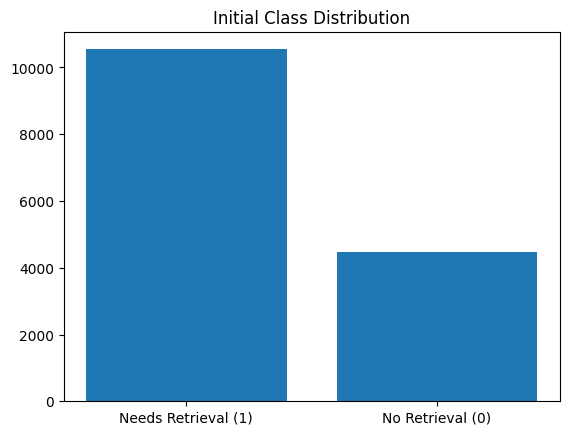

In [3]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

# Load dataset from the task paper
dataset = load_dataset("databricks/databricks-dolly-15k")

# Label based on context presence
dataset = dataset.map(lambda x: {"labels": 1 if x["context"] else 0})

# Plot initial class distribution
label_counts = dataset["train"].to_pandas()["labels"].value_counts()
plt.bar(['Needs Retrieval (1)', 'No Retrieval (0)'], label_counts)
plt.title('Initial Class Distribution')
plt.show()

## 2. Class Balancing with Undersampling
### Why undersampling? Have no time to make it better, but also:
- Addresses class imbalance by reducing majority class samples
- Reduces training time as I have not been provided with spare gpu server to train (Using free tier Colab)

In [4]:
# Undersampling implementation
minority_class = label_counts.idxmin()
minority_count = label_counts.min()

minority_indices = [i for i, x in enumerate(dataset["train"]) if x["labels"] == minority_class]
majority_indices = [i for i, x in enumerate(dataset["train"]) if x["labels"] != minority_class]

np.random.seed(42)
undersampled_majority = np.random.choice(majority_indices, minority_count, replace=False)
balanced_indices = np.concatenate([minority_indices, undersampled_majority])
np.random.shuffle(balanced_indices)

# Create balanced dataset
balanced_dataset = dataset["train"].select(balanced_indices)
dataset = balanced_dataset.class_encode_column("labels").train_test_split(test_size=0.3, stratify_by_column="labels")
dataset

Stringifying the column:   0%|          | 0/8934 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/8934 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'labels'],
        num_rows: 6253
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'labels'],
        num_rows: 2681
    })
})

## 3. Model Initialization
### Why ModernBERT-base:
- State-of-the-art for classification tasks
- Optimized attention mechanisms
- Native support for sequence classification

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0: "No_Retrieval", 1: "Needs_Retrieval"},
    trust_remote_code=True
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def tokenize_function(examples):
    return tokenizer(
        examples["instruction"],
        truncation=True,
        max_length=512,
        padding="max_length"
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=['instruction', 'context', 'response', 'category'])
print("Tokenized dataset sample:", tokenized_datasets["train"][0])

Map:   0%|          | 0/6253 [00:00<?, ? examples/s]

Map:   0%|          | 0/2681 [00:00<?, ? examples/s]

Tokenized dataset sample: {'labels': 1, 'input_ids': [50281, 1276, 310, 7785, 14, 35, 1120, 4907, 846, 32, 50282, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 5028

In [7]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 6253
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2681
    })
})

## 4. Training Configuration
### Key Hyperparameters:
- Learning Rate: 2e-5 (optimal for fine-tuning)
- Batch Size: 32 (fits in GPU T4 memory)
- Epochs: 3 (prevents overfitting)
- FP16: Enabled (faster training)

In [12]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate

training_args = TrainingArguments(
    output_dir="rag_classifier",
    num_train_epochs=3,
    warmup_steps=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=50,
    learning_rate=2e-5,
    save_steps=50,
    fp16=True,
    logging_dir="./logs",
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Evaluation metrics same as in the paper
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"]
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1576: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## 5. Model Training & Evaluation
### Training Monitoring:
- Per-steps validation
- All scores tracking

In [9]:
# Start training
trainer.train()

# Save final model
trainer.save_model("best_rag_classifier")

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.366800,0.383492,0.806789,0.805702,0.813763,0.806789
100,0.385900,0.363314,0.813129,0.811959,0.821074,0.813129
150,0.346400,0.337810,0.829541,0.829384,0.830745,0.829541
200,0.341200,0.372599,0.812383,0.809470,0.832652,0.812383
250,0.322200,0.351200,0.825438,0.824849,0.829913,0.825438
300,0.283300,0.358557,0.835136,0.834402,0.841144,0.835136
350,0.267500,0.331376,0.842596,0.842558,0.842935,0.842596
400,0.176500,0.333945,0.844088,0.844064,0.844311,0.844088
450,0.246400,0.388114,0.837001,0.836719,0.839323,0.837001
500,0.176200,0.362084,0.841850,0.841849,0.841857,0.841850


Could not locate the best model at rag_classifier/checkpoint-350/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


In [15]:
# Move model to the personal google disk
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
!cp -r /content/best_rag_classifier/ /content/drive/MyDrive